In [81]:
import pandas as pd
from holidays import UnitedStates
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Datasets Reading

In [82]:
taxi_df = pd.read_csv("dataset.csv", index_col=0)
# Create a new row for 2015-02-01 00:00:00
new_row = {'timestamp': pd.Timestamp('2015-02-01 00:00:00'), 'value': np.nan}

# Append the new row to the original DataFrame
taxi_df.loc[len(taxi_df)] = new_row
taxi_df

,timestamp,value
0,2014-07-01 00:00:00,10844.0
1,2014-07-01 00:30:00,8127.0
2,2014-07-01 01:00:00,6210.0
3,2014-07-01 01:30:00,4656.0
4,2014-07-01 02:00:00,3820.0
...,...,...
10316,2015-01-31 22:00:00,25721.0
10317,2015-01-31 22:30:00,27309.0
10318,2015-01-31 23:00:00,26591.0
10319,2015-01-31 23:30:00,26288.0


In [83]:
print(taxi_df.isnull().sum())
taxi_df.info()

timestamp    0
value        1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 10321 entries, 0 to 10320
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  10321 non-null  object 
 1   value      10320 non-null  float64
dtypes: float64(1), object(1)
memory usage: 241.9+ KB


In [84]:
weather_df = pd.read_csv('weather_csv.csv')
weather_df.head()

,timestamp,prep,snow,min_temp,max_temp
0,2014-07-01,0.00,0.0,0.0,72.0
1,2014-07-02,0.96,0.0,0.0,72.0
2,2014-07-03,1.78,0.0,0.0,69.0
3,2014-07-04,0.14,0.0,0.0,65.0
4,2014-07-05,0.00,0.0,0.0,63.0


In [85]:
print(weather_df.isnull().sum())
weather_df.info()

timestamp    0
prep         0
snow         0
min_temp     0
max_temp     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  216 non-null    object 
 1   prep       216 non-null    float64
 2   snow       216 non-null    float64
 3   min_temp   216 non-null    float64
 4   max_temp   216 non-null    float64
dtypes: float64(4), object(1)
memory usage: 8.6+ KB


In [86]:
# Create a holiday object for the US with state-specific holidays for New York
ny_holidays = UnitedStates(years=[2014, 2015], state='NY')

# Convert to a DataFrame
holidays_df = pd.DataFrame({
    "Date": list(ny_holidays.keys()),
    "Holiday": list(ny_holidays.values())
})

# Convert 'Date' to datetime
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])

# Filter holidays up to '2015-01-31'
holidays_df = holidays_df.loc[(holidays_df['Date'] <= '2015-01-31') & (holidays_df['Date'] >= '2014-07-01')]

# Sort by index and rename the column "Date" to "timestamp"
holidays_df = holidays_df.sort_values(by=['Date'])

# Show the final DataFrame
holidays_df

,Date,Holiday
2,2014-07-04,Independence Day
3,2014-09-01,Labor Day
9,2014-10-13,Columbus Day
12,2014-11-04,Election Day
4,2014-11-11,Veterans Day
5,2014-11-27,Thanksgiving
6,2014-12-25,Christmas Day
13,2015-01-01,New Year's Day
21,2015-01-19,Martin Luther King Jr. Day


In [87]:
taxi_df['timestamp'] = pd.to_datetime(taxi_df['timestamp'])
taxi_df['year'] = taxi_df['timestamp'].dt.year
taxi_df['month'] = taxi_df['timestamp'].dt.month
taxi_df['day'] = taxi_df['timestamp'].dt.day
taxi_df['Date'] = taxi_df['timestamp'].dt.date
taxi_df['Date'] = taxi_df['Date'].apply(pd.to_datetime).dt.date
taxi_df['day_of_week'] = taxi_df['timestamp'].dt.day_of_week + 1
taxi_df['hour'] = taxi_df['timestamp'].dt.hour
taxi_df['isWeekend'] = taxi_df.day_of_week.map({1: False, 2: False, 3: False, 4: False, 5: False, 6: True, 7: True})

# Add time parts to the anomaly dates and update the 'isAnomaly' column
taxi_df['isAnomaly'] = False
anomaly_dates = ['2014-11-02', '2014-11-27', '2014-12-24', '2014-12-25', '2015-01-01', '2015-01-26', '2015-01-27']

anomaly_dates = [pd.to_datetime(date).date() for date in anomaly_dates]
taxi_df['isAnomaly'] = taxi_df['Date'].isin(anomaly_dates)

# View the dataset for verification
taxi_df.loc[taxi_df['isAnomaly']][['Date', 'isAnomaly']]

,Date,isAnomaly
5952,2014-11-02,True
5953,2014-11-02,True
5954,2014-11-02,True
5955,2014-11-02,True
5956,2014-11-02,True
...,...,...
10123,2015-01-27,True
10124,2015-01-27,True
10125,2015-01-27,True
10126,2015-01-27,True


In [88]:
taxi_df

,timestamp,value,year,month,day,Date,day_of_week,hour,isWeekend,isAnomaly
0,2014-07-01 00:00:00,10844.0,2014,7,1,2014-07-01,2,0,False,False
1,2014-07-01 00:30:00,8127.0,2014,7,1,2014-07-01,2,0,False,False
2,2014-07-01 01:00:00,6210.0,2014,7,1,2014-07-01,2,1,False,False
3,2014-07-01 01:30:00,4656.0,2014,7,1,2014-07-01,2,1,False,False
4,2014-07-01 02:00:00,3820.0,2014,7,1,2014-07-01,2,2,False,False
...,...,...,...,...,...,...,...,...,...,...
10316,2015-01-31 22:00:00,25721.0,2015,1,31,2015-01-31,6,22,True,False
10317,2015-01-31 22:30:00,27309.0,2015,1,31,2015-01-31,6,22,True,False
10318,2015-01-31 23:00:00,26591.0,2015,1,31,2015-01-31,6,23,True,False
10319,2015-01-31 23:30:00,26288.0,2015,1,31,2015-01-31,6,23,True,False


Merging datasets

In [89]:
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
taxi_df['Date'] = pd.to_datetime(taxi_df['Date'])
merged_data = pd.merge(taxi_df, holidays_df, how='left', on='Date')

weather_df['timestamp'] = weather_df['timestamp'] + ' 00:00:00'
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'] + ' 00:00:00')
weather_df['timestamp'] = weather_df['timestamp'].dt.normalize()
weather_df
merged_data = pd.merge(merged_data, weather_df, how='left', on='timestamp')
merged_data.loc[~merged_data['Holiday'].isnull()]

C:\Users\weare\AppData\Local\Temp\ipykernel_22760\2614963403.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'] + ' 00:00:00')


,timestamp,value,year,month,day,Date,day_of_week,hour,isWeekend,isAnomaly,Holiday,prep,snow,min_temp,max_temp
144,2014-07-04 00:00:00,15591.0,2014,7,4,2014-07-04,5,0,False,False,Independence Day,0.14,0.0,0.0,65.0
145,2014-07-04 00:30:00,14395.0,2014,7,4,2014-07-04,5,0,False,False,Independence Day,NaN,NaN,NaN,NaN
146,2014-07-04 01:00:00,12535.0,2014,7,4,2014-07-04,5,1,False,False,Independence Day,NaN,NaN,NaN,NaN
147,2014-07-04 01:30:00,11341.0,2014,7,4,2014-07-04,5,1,False,False,Independence Day,NaN,NaN,NaN,NaN
148,2014-07-04 02:00:00,9980.0,2014,7,4,2014-07-04,5,2,False,False,Independence Day,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9739,2015-01-19 21:30:00,14069.0,2015,1,19,2015-01-19,1,21,False,False,Martin Luther King Jr. Day,NaN,NaN,NaN,NaN
9740,2015-01-19 22:00:00,13506.0,2015,1,19,2015-01-19,1,22,False,False,Martin Luther King Jr. Day,NaN,NaN,NaN,NaN
9741,2015-01-19 22:30:00,12936.0,2015,1,19,2015-01-19,1,22,False,False,Martin Luther King Jr. Day,NaN,NaN,NaN,NaN
9742,2015-01-19 23:00:00,10400.0,2015,1,19,2015-01-19,1,23,False,False,Martin Luther King Jr. Day,NaN,NaN,NaN,NaN


In [90]:
dataset = merged_data.copy()
dataset

,timestamp,value,year,month,day,Date,day_of_week,hour,isWeekend,isAnomaly,Holiday,prep,snow,min_temp,max_temp
0,2014-07-01 00:00:00,10844.0,2014,7,1,2014-07-01,2,0,False,False,NaN,0.00,0.0,0.0,72.0
1,2014-07-01 00:30:00,8127.0,2014,7,1,2014-07-01,2,0,False,False,NaN,NaN,NaN,NaN,NaN
2,2014-07-01 01:00:00,6210.0,2014,7,1,2014-07-01,2,1,False,False,NaN,NaN,NaN,NaN,NaN
3,2014-07-01 01:30:00,4656.0,2014,7,1,2014-07-01,2,1,False,False,NaN,NaN,NaN,NaN,NaN
4,2014-07-01 02:00:00,3820.0,2014,7,1,2014-07-01,2,2,False,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10316,2015-01-31 22:00:00,25721.0,2015,1,31,2015-01-31,6,22,True,False,NaN,NaN,NaN,NaN,NaN
10317,2015-01-31 22:30:00,27309.0,2015,1,31,2015-01-31,6,22,True,False,NaN,NaN,NaN,NaN,NaN
10318,2015-01-31 23:00:00,26591.0,2015,1,31,2015-01-31,6,23,True,False,NaN,NaN,NaN,NaN,NaN
10319,2015-01-31 23:30:00,26288.0,2015,1,31,2015-01-31,6,23,True,False,NaN,NaN,NaN,NaN,NaN


Filling the missing values

In [91]:
dataset = dataset[['timestamp','value','month','day','day_of_week','isWeekend','isAnomaly','Holiday','prep','snow','min_temp','max_temp']]
dataset['isHoliday'] = False
dataset.loc[~dataset['Holiday'].isnull(),'isHoliday'] = True
dataset

C:\Users\weare\AppData\Local\Temp\ipykernel_22760\2780636988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['isHoliday'] = False


,timestamp,value,month,day,day_of_week,isWeekend,isAnomaly,Holiday,prep,snow,min_temp,max_temp,isHoliday
0,2014-07-01 00:00:00,10844.0,7,1,2,False,False,NaN,0.00,0.0,0.0,72.0,False
1,2014-07-01 00:30:00,8127.0,7,1,2,False,False,NaN,NaN,NaN,NaN,NaN,False
2,2014-07-01 01:00:00,6210.0,7,1,2,False,False,NaN,NaN,NaN,NaN,NaN,False
3,2014-07-01 01:30:00,4656.0,7,1,2,False,False,NaN,NaN,NaN,NaN,NaN,False
4,2014-07-01 02:00:00,3820.0,7,1,2,False,False,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10316,2015-01-31 22:00:00,25721.0,1,31,6,True,False,NaN,NaN,NaN,NaN,NaN,False
10317,2015-01-31 22:30:00,27309.0,1,31,6,True,False,NaN,NaN,NaN,NaN,NaN,False
10318,2015-01-31 23:00:00,26591.0,1,31,6,True,False,NaN,NaN,NaN,NaN,NaN,False
10319,2015-01-31 23:30:00,26288.0,1,31,6,True,False,NaN,NaN,NaN,NaN,NaN,False


In [92]:
# Save the merged_data DataFrame to a CSV file
dataset.to_csv('updated_dataset.csv', index=False)

In [93]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset = dataset.set_index("timestamp")
print(dataset.isnull().sum())
print()
dataset.describe()

C:\Users\weare\AppData\Local\Temp\ipykernel_22760\1830696519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])


value              1
month              0
day                0
day_of_week        0
isWeekend          0
isAnomaly          0
Holiday         9889
prep           10105
snow           10105
min_temp       10105
max_temp       10105
isHoliday          0
dtype: int64



,value,month,day,day_of_week,prep,snow,min_temp,max_temp
count,10320.000000,10321.000000,10321.000000,10321.000000,216.000000,216.000000,216.000000,216.000000
mean,15137.569380,8.269160,15.859025,4.000291,0.141806,0.085185,0.248611,49.777778
std,6939.495808,3.379261,8.868658,1.988557,0.366058,0.552005,1.191598,17.416823
min,8.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,8.000000
25%,10262.000000,7.000000,8.000000,2.000000,0.000000,0.000000,0.000000,35.000000
50%,16778.000000,9.000000,16.000000,4.000000,0.000000,0.000000,0.000000,52.500000
75%,19838.750000,11.000000,24.000000,6.000000,0.060000,0.000000,0.000000,65.250000
max,39197.000000,12.000000,31.000000,7.000000,2.540000,5.500000,7.900000,77.000000


# Data Analysis

Total taxi passengers by specific times group

In [96]:
def make_graph(interval=None):
    # Plotting the main "value" series
    if interval is None:
        graph = dataset['value']
        anomaly = dataset.loc[dataset['isAnomaly'], 'value']
        title = 'Passengers Throughout the Data'
    else:
        start, end = interval  # Unpack the start and end dates
        graph = dataset.loc[start:end, 'value']
        anomaly = dataset.loc[
            (dataset.index >= start) & (dataset.index <= end) & (dataset['isAnomaly']),
            'value'
        ]
        title = f'Passengers from {start} to {end}'

    # Plot the main graph
    graph.plot(figsize=(10, 6), color='blue', linewidth=1, label='Taxi Passengers')

    # Plot anomalies if they exist
    if not anomaly.empty:
        anomaly.plot(
            linestyle='None',
            marker='o',
            color='red',
            markersize=5,
            label='Anomalies'
        )

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Taxi Passengers')
    plt.title(title)

    # Rotating x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Adding a grid with some transparency
    plt.grid(True, linestyle='--', alpha=0.2)

    # Displaying the legend to differentiate the series
    plt.legend()

    # Show the plot
    plt.show()

    

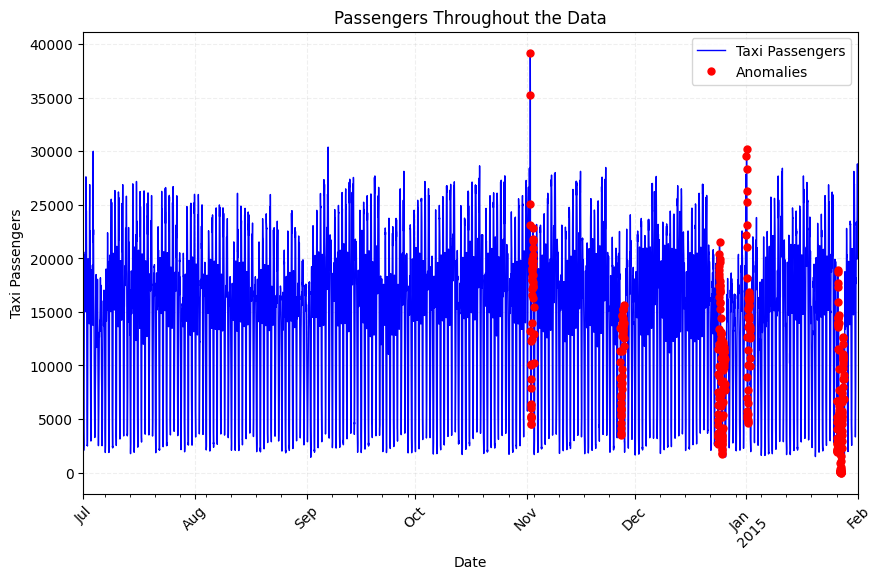

In [97]:
make_graph()

3 consecutive normal and anomalous weeks

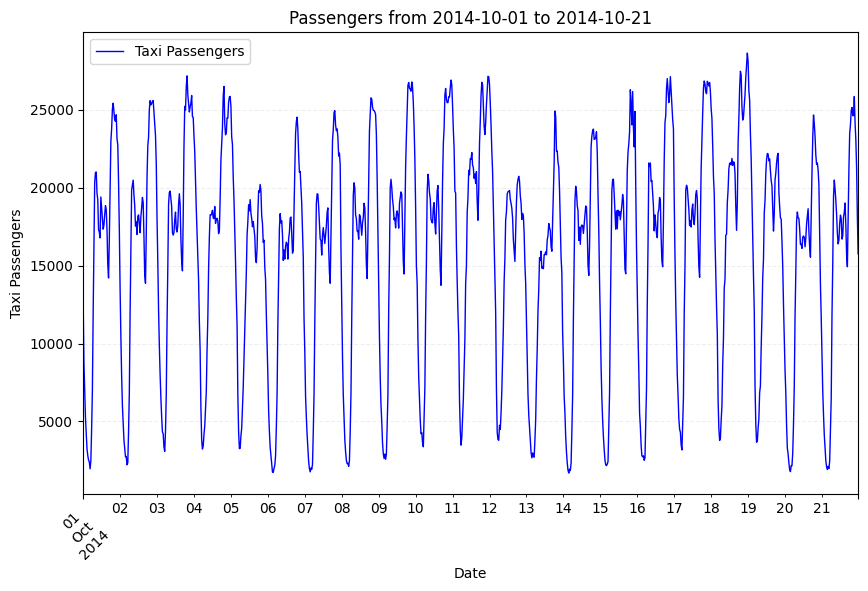

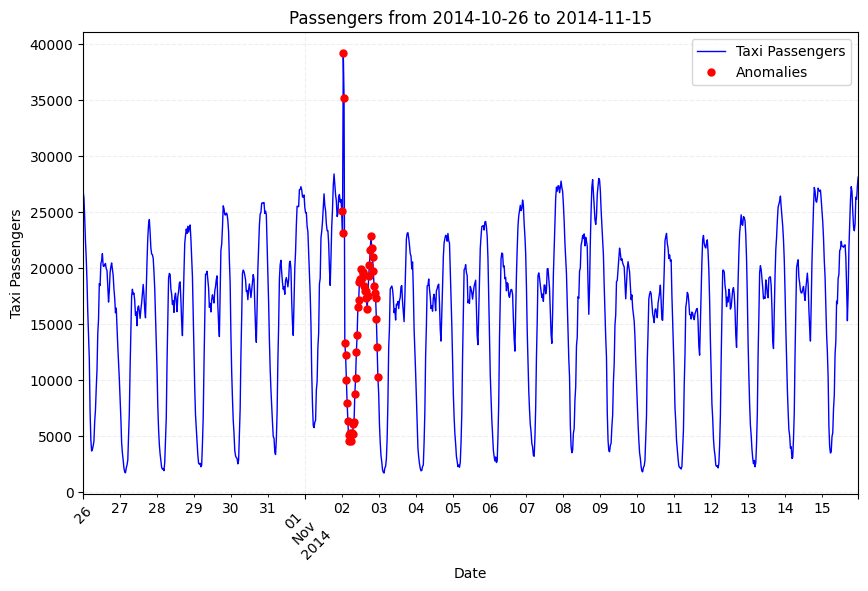

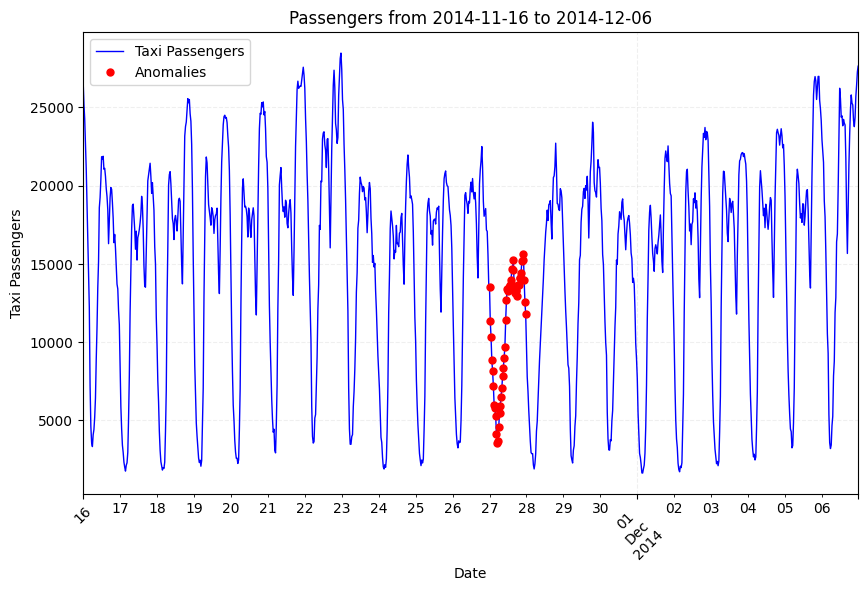

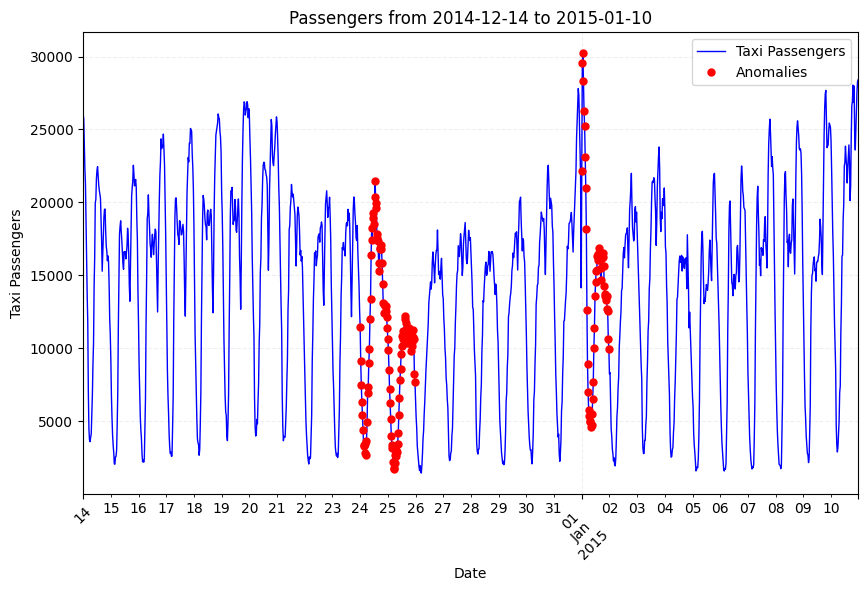

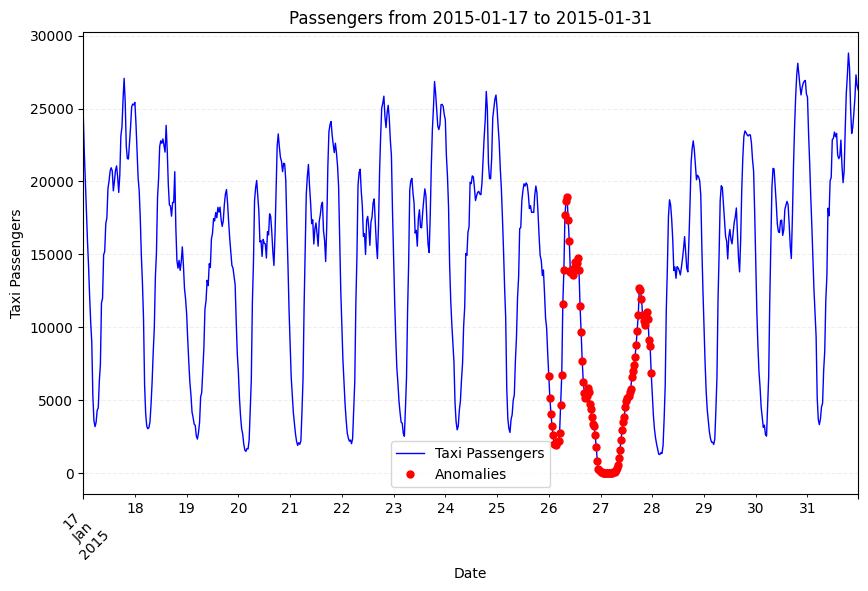

In [98]:
consicutive_weeks = [ 
        ['2014-10-01','2014-10-21'], # Normal
        ['2014-10-26','2014-11-15'], # Annual Marathon
        ['2014-11-16','2014-12-06'], # Thanksgiving
        ['2014-12-14','2015-01-10'], # Christmas and New Years
        ['2015-01-17','2015-01-31'] # Snowstorm
    ]
# Iterate over anomaly periods and plot
for interval in consicutive_weeks:
    make_graph(interval)
